We are going to explore the method of Layerwise Relevance Propagation to identify which features are most important in the decision process of the IN. The details of the LRP method can be found in [this paper](https://doi.org/10.1007/978-3-030-28954-6_10). The original LRP rule has been developed for simple networks like MLPs. For a classification problem, the total relevance score is taken as the netowrk's output for the corresponding class. This relevance score is propagated back to the previous layers following the LRP rule-

\begin{equation}
r_j^{(n)} = \frac{a_j^{(n)}w_{jk:n}}{\sum_k a_j^{(n)}w_{jk:n}}r_k^{(n+1)}
\end{equation}

here $a_j^{(n)}$ and $r_j^{(n)}$ are the activation and relevance scores of the $j$-th node in $n$-th layer and $w_{jk:n}$ is the weight that determines the contribution of the $j$-th activation in the $n$-th layer to the $k$-th node in layer $n+1$. This rule is called the LRP-0 rule, since it uses the exact values for the weights and activations without any regularization.

We'll start by setting up the code and loading the baseline model.

In [31]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import glob
import json
import torch.nn as nn
import os
from matplotlib import colors
import sys

sys.path.append("..")
sys.path.append("../src")
from models import models
from data import h5data
from utils import xAITools as xai

params = [
    "track_ptrel",
    "track_erel",
    "track_phirel",
    "track_etarel",
    "track_deltaR",
    "track_drminsv",
    "track_drsubjet1",
    "track_drsubjet2",
    "track_dz",
    "track_dzsig",
    "track_dxy",
    "track_dxysig",
    "track_normchi2",
    "track_quality",
    "track_dptdpt",
    "track_detadeta",
    "track_dphidphi",
    "track_dxydxy",
    "track_dzdz",
    "track_dxydz",
    "track_dphidxy",
    "track_dlambdadz",
    "trackBTag_EtaRel",
    "trackBTag_PtRatio",
    "trackBTag_PParRatio",
    "trackBTag_Sip2dVal",
    "trackBTag_Sip2dSig",
    "trackBTag_Sip3dVal",
    "trackBTag_Sip3dSig",
    "trackBTag_JetDistVal",
]

params_sv = [
    "sv_ptrel",
    "sv_erel",
    "sv_phirel",
    "sv_etarel",
    "sv_deltaR",
    "sv_pt",
    "sv_mass",
    "sv_ntracks",
    "sv_normchi2",
    "sv_dxy",
    "sv_dxysig",
    "sv_d3d",
    "sv_d3dsig",
    "sv_costhetasvpv",
]

softmax = torch.nn.Softmax(dim=1)
batch_size = 128
Ntracks = 60
Nverts = 5
Nclasses = 2
files = glob.glob("../src/models/dataset/train/newdata_*.h5")
files_val = files[:5]  # take first 5 for validation
data_val = h5data.H5Data(
    batch_size=batch_size,
    cache=None,
    preloading=0,
    features_name="training_subgroup",
    labels_name="target_subgroup",
    spectators_name="spectator_subgroup",
)
data_val.set_file_names(files_val)

In [32]:
model_name = "gnn_psvfeaturesdropped_001_noTrackQ_best.pth"
# model_name = "gnn_baseline_best.pth"
def_state_dict = torch.load("../models/trained_models/" + model_name)

try:
    model_metadata = json.load(open("../models/model_dicts/" + model_name.replace("best.pth", "model_metadata.json")))
    try:
        pfeats_to_drop = list(map(int, model_metadata["drop_pfeatures"].strip().split(",")))
    except:
        pfeats_to_drop = []
    try:
        svfeats_to_drop = list(map(int, model_metadata["drop_svfeatures"].strip().split(",")))
    except:
        svfeats_to_drop = []
    Do = model_metadata["Do"]
    De = model_metadata["De"]
    hidden = model_metadata["hidden"]
    model_label = model_metadata["label"]
except:
    print("Model not found!")

for key in def_state_dict.keys():
    print(key, def_state_dict[key].shape)


gnn_0 = models.GraphNet(
    Ntracks,
    Nclasses,
    len(params) - len(pfeats_to_drop),
    hidden,
    Nverts,
    len(params_sv) - len(svfeats_to_drop),
    vv_branch=0,
    De=De,
    Do=Do,
)

gnn_0.load_state_dict(def_state_dict)

fr1.weight torch.Size([60, 36])
fr1.bias torch.Size([60])
fr2.weight torch.Size([60, 60])
fr2.bias torch.Size([60])
fr3.weight torch.Size([20, 60])
fr3.bias torch.Size([20])
fr1_pv.weight torch.Size([60, 27])
fr1_pv.bias torch.Size([60])
fr2_pv.weight torch.Size([60, 60])
fr2_pv.bias torch.Size([60])
fr3_pv.weight torch.Size([20, 60])
fr3_pv.bias torch.Size([20])
fo1.weight torch.Size([60, 58])
fo1.bias torch.Size([60])
fo2.weight torch.Size([60, 60])
fo2.bias torch.Size([60])
fo3.weight torch.Size([24, 60])
fo3.bias torch.Size([24])
fc_fixed.weight torch.Size([2, 24])
fc_fixed.bias torch.Size([2])


<All keys matched successfully>

Now let's define the method to calculate the LRP scores. The same method is expected to generate all variants of the LRP algorithm, the LRP-0 rule mentioned above as well as the LRP-$\epsilon$ and LRP-$\gamma$ rules.

While the rule of propagation across MLP layers is well defined, we need to also figure out how to redistribute the relevances across the following operations that have been exclusively defined for the IN model.

First, to propagate the relevances for the operation of summing internal representation of track features obtained from the aggregator network $(O_{[D_o \times N_p]} \rightarrow \bar{O}_{[D_o]})$, we'll use the following relation-

\begin{equation}
r_{kn} = \bar{r}_k\frac{o_{kn}}{\bar{o}_{k}}
\end{equation}

where $\bar{r}$ represents the LRP scores for the summed internal representation.

Second, the interaction matrices $R_R$ and $R_K$ propagate edge level internal space representation to the individual particle tracks $({E}_{pp}[D_e \times N_{pp}] \rightarrow \bar{E}_{pp}[D_e \times N_{p}]$ and ${E}_{vp}[D_e \times N_{vp}] \rightarrow \bar{E}_{vp}[D_e \times N_{p}] )$. To propagate the relevances across these operations, we'll use the relation-

\begin{equation}
r_{km} = e_{km}\sum_n\frac{\bar{r}_{kn}}{\bar{e}_{kn}}R_{R/K, nm}
\end{equation}


In [33]:
pred, target = xai.eval(
    model=gnn_0, data=data_val, drop_pfeatures=pfeats_to_drop, drop_svfeatures=svfeats_to_drop, save_data=False
)

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(target[:, 1], pred[:, 1])
print("AUC score for '{}' model:".format(model_label), auc(fpr, tpr))

AUC score for 'psvfeaturesdropped_001_noTrackQ' model: 0.9900246059755057


Now we will explore the average LRP scores for input features. We use the LRP-$\gamma$ method with $\gamma = 2.0$. Other choices can be explore by changing the relevant variables in the code snippet below.

In [61]:
Pall_0 = []
Vall_0 = []
Pall_1 = []
Vall_1 = []
count_0 = 0
count_1 = 0
idx = 0
nmax = 30
LRP_mode = "gamma"
eps = 0.4
gamma = 2.0
dendrop_threshold = 0.0
tag = LRP_mode + ("_{}".format(eps) if LRP_mode == "eps" else ("_{}".format(gamma) if LRP_mode == "gamma" else ""))
tag += "_" + model_label
HiddenRelevance_0 = []
HiddenRelevance_1 = []
do_sorting = True
with torch.no_grad():
    for sub_X, sub_Y, sub_Z in data_val.generate_data():
        training = sub_X[2]
        training_sv = sub_X[3]
        target = sub_Y[0]
        spec = sub_Z[0]
        trainingv = (torch.FloatTensor(training)).cuda()
        if do_sorting:
            _, inds = torch.sort(torch.tensor(trainingv[:, 1, :]), descending=True)  # descending order of rel_e
            for ii in range(trainingv.shape[0]):
                trainingv[ii] = trainingv[ii][:, inds[ii]]
        trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
        if do_sorting:
            _, inds = torch.sort(torch.tensor(trainingv_sv[:, 5, :]), descending=True)  # descending order of sv_pt
            for ii in range(trainingv_sv.shape[0]):
                trainingv_sv[ii] = trainingv_sv[ii][:, inds[ii]]

        if len(pfeats_to_drop) > 0:
            keep_features = [i for i in np.arange(0, len(params), 1, dtype=int) if i not in pfeats_to_drop]
            trainingv = trainingv[:, keep_features, :]
        # trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
        if len(svfeats_to_drop) > 0:
            keep_features = [i for i in np.arange(0, len(params_sv), 1, dtype=int) if i not in svfeats_to_drop]
            trainingv_sv = trainingv_sv[:, keep_features, :]

        keep_indices = target[:, 1] == 0

        if keep_indices.sum().item() > 0:
            N, P, V, H, tags = xai.LRPEvaluator(
                model=gnn_0,
                x=trainingv[keep_indices, :, :],
                y=trainingv_sv[keep_indices, :, :],
                def_state_dict=def_state_dict,
                target=0,
                LRP_mode=LRP_mode,
                eps=eps,
                gamma=gamma,
                dendrop_threshold=dendrop_threshold,
                include_bias=False,
            )
            print(
                "Batch: {}, target: 0, count = {}, Psum = {}, Vsum = {}".format(
                    idx, N.shape[0], P.sum().item(), V.sum().item()
                )
            )
            # Pall_0 += P.detach().cpu()
            # Vall_0 += V.detach().cpu()
            Pall_0.append(P.detach().cpu())
            Vall_0.append(V.detach().cpu())
            count_0 += keep_indices.sum().item()
            if idx == 0:
                for hr in H:
                    HiddenRelevance_0.append(hr)
            else:
                for ii, hr in enumerate(H):
                    HiddenRelevance_0[ii] += hr
        keep_indices = target[:, 1] == 1
        if keep_indices.sum().item() > 0:
            N, P, V, H, tags = xai.LRPEvaluator(
                model=gnn_0,
                x=trainingv[keep_indices, :, :],
                y=trainingv_sv[keep_indices, :, :],
                def_state_dict=def_state_dict,
                target=1,
                LRP_mode=LRP_mode,
                eps=eps,
                gamma=gamma,
                dendrop_threshold=dendrop_threshold,
                include_bias=False,
            )

            print(
                "Batch: {}, target: 1, count = {}, Psum = {}, Vsum = {}".format(
                    idx, N.shape[0], P.sum().item(), V.sum().item()
                )
            )
            # Pall_1 += P.detach().cpu()
            # Vall_1 += V.detach().cpu()
            Pall_1.append(P.detach().cpu())
            Vall_1.append(V.detach().cpu())
            count_1 += keep_indices.sum().item()
            if idx == 0:
                for hr in H:
                    HiddenRelevance_1.append(hr)
            else:
                for ii, hr in enumerate(H):
                    HiddenRelevance_1[ii] += hr

        idx += 1
        if idx == nmax:
            break

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch: 0, target: 0, count = 80, Psum = 77.03515625, Vsum = 3.194746255874634
Batch: 0, target: 1, count = 48, Psum = 43.990196228027344, Vsum = 3.5033531188964844
Batch: 1, target: 0, count = 94, Psum = 90.69931030273438, Vsum = 3.645461082458496
Batch: 1, target: 1, count = 34, Psum = 30.596866607666016, Vsum = 3.0773675441741943
Batch: 2, target: 0, count = 97, Psum = 93.95756530761719, Vsum = 3.453278064727783
Batch: 2, target: 1, count = 31, Psum = 27.792766571044922, Vsum = 2.3307461738586426
Batch: 3, target: 0, count = 71, Psum = 68.86266326904297, Vsum = 2.1642062664031982
Batch: 3, target: 1, count = 57, Psum = 50.41691207885742, Vsum = 5.862112045288086
Batch: 4, target: 0, count = 90, Psum = 87.79936218261719, Vsum = 2.800975799560547
Batch: 4, target: 1, count = 38, Psum = 34.99348068237305, Vsum = 3.014826536178589
Batch: 5, target: 0, count = 82, Psum = 79.67345428466797, Vsum = 2.6987152099609375
Batch: 5, target: 1, count = 46, Psum = 41.64579391479492, Vsum = 3.878346

Now we'll separate the scores for the two jet categories.

In [62]:
Pall_0 = torch.cat(Pall_0).sum(dim=0) / count_0  # track scores for QCD
Pall_1 = torch.cat(Pall_1).sum(dim=0) / count_1  # track scores for Hbb
Vall_0 = torch.cat(Vall_0).sum(dim=0) / count_0  # vertex scores for QCD
Vall_1 = torch.cat(Vall_1).sum(dim=0) / count_1  # vertex scores for QCD

In [63]:
params_to_keep = [params[i] for i in range(len(params)) if i not in pfeats_to_drop]
params_sv_to_keep = [params_sv[i] for i in range(len(params_sv)) if i not in svfeats_to_drop]

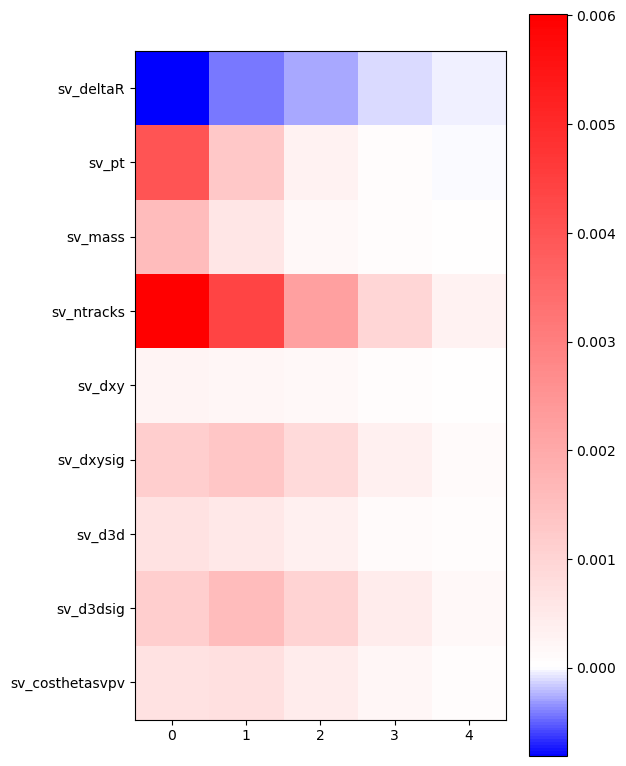

In [64]:
plt.figure(figsize=(6, 8))
divnorm = colors.TwoSlopeNorm(vmin=min(Vall_0.min(), 0), vcenter=max(Vall_0.min(), 0) + 1.0e-5, vmax=Vall_0.max())
plt.imshow(Vall_0.numpy(), cmap="bwr", interpolation="None", norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_sv_to_keep)), labels=params_sv_to_keep)
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/sv0_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

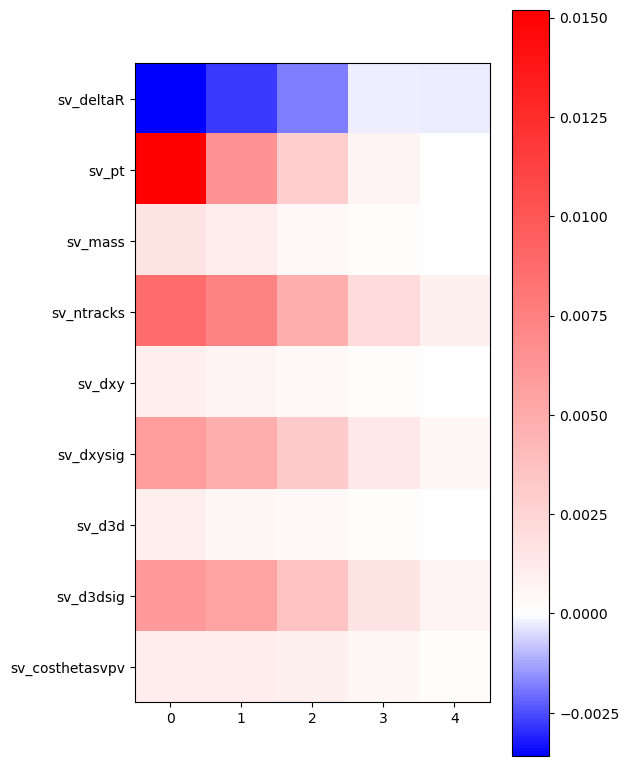

In [65]:
plt.figure(figsize=(6, 8))
divnorm = colors.TwoSlopeNorm(vmin=min(Vall_1.min(), 0), vcenter=max(Vall_1.min(), 0) + 1.0e-5, vmax=Vall_1.max())
plt.imshow(Vall_1.numpy(), cmap="bwr", interpolation="None", norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_sv_to_keep)), labels=params_sv_to_keep)
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/sv1_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

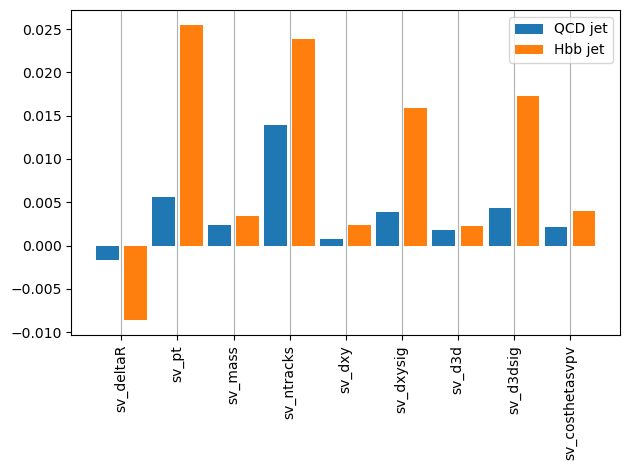

In [66]:
pos = 2 * np.arange(len(params_sv_to_keep))
plt.bar(pos, torch.sum(Vall_0, 1).numpy(), align="center", label="QCD jet")
plt.bar(pos + 1, torch.sum(Vall_1, 1).numpy(), align="center", label="Hbb jet")
plt.xticks(pos + 0.5, params_sv_to_keep, rotation="vertical")
plt.legend()
plt.grid(axis="x")
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/sv_feats_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

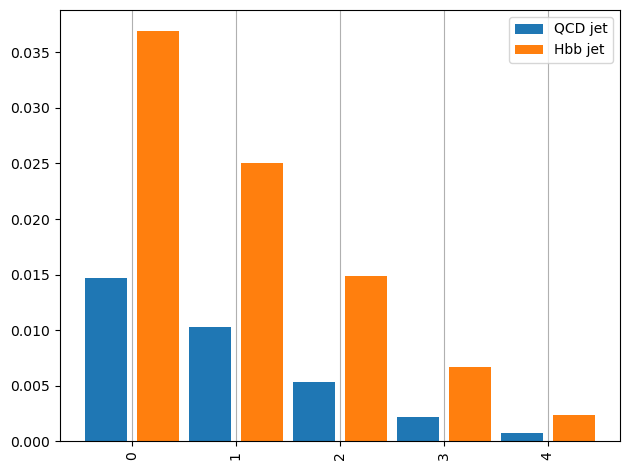

In [67]:
pos = 2 * np.arange(Nverts)
plt.bar(pos, torch.sum(Vall_0, 0).numpy(), align="center", label="QCD jet")
plt.bar(pos + 1, torch.sum(Vall_1, 0).numpy(), align="center", label="Hbb jet")
plt.xticks(pos + 0.5, list(map(int, pos / 2)), rotation="vertical")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/sv_vertices_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

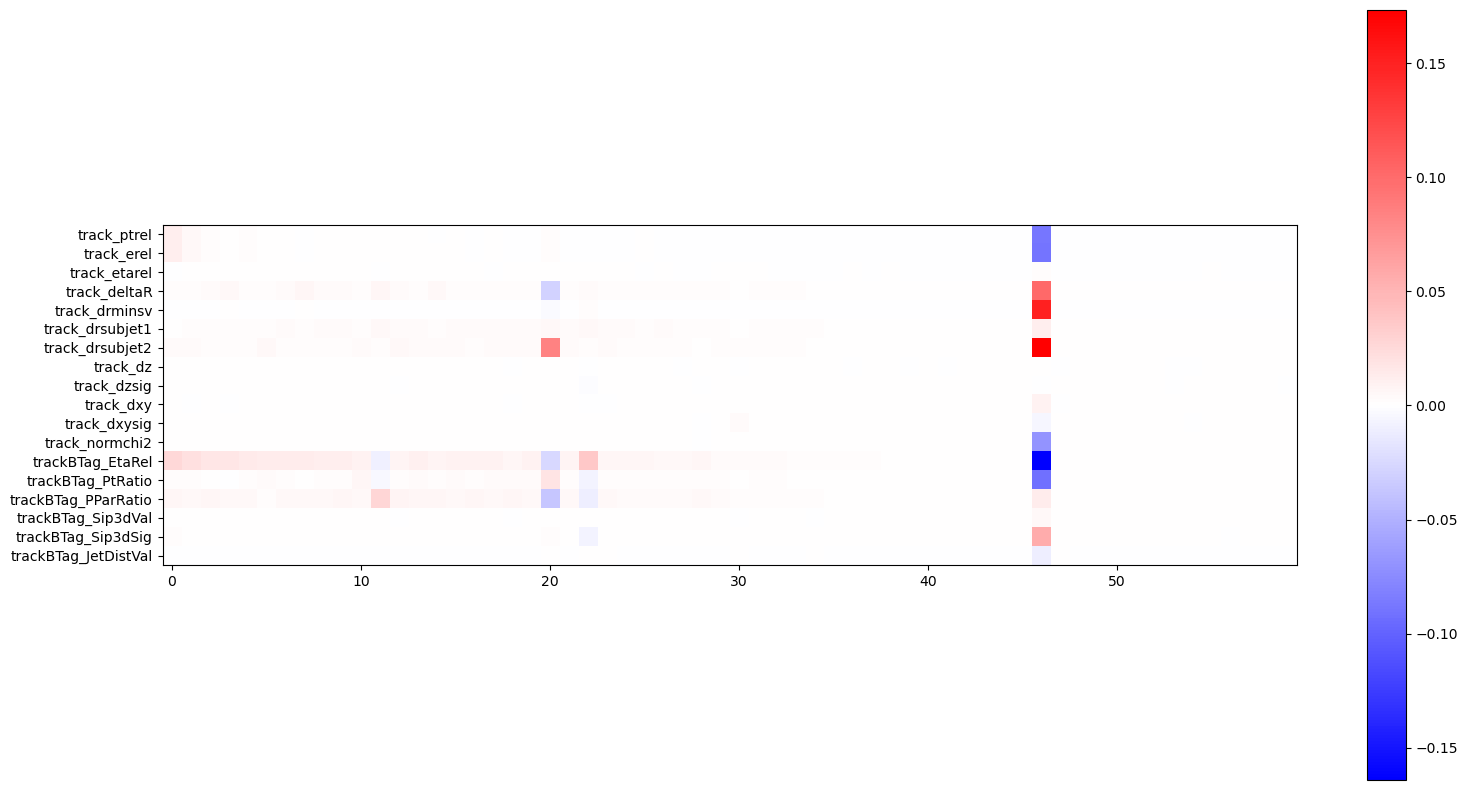

In [68]:
plt.figure(figsize=(16, 8))
divnorm = colors.TwoSlopeNorm(vmin=Pall_0.min(), vcenter=0.0, vmax=Pall_0.max())
plt.imshow(Pall_0.numpy(), cmap="bwr", interpolation="None", norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_to_keep)), labels=params_to_keep)
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/track0_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

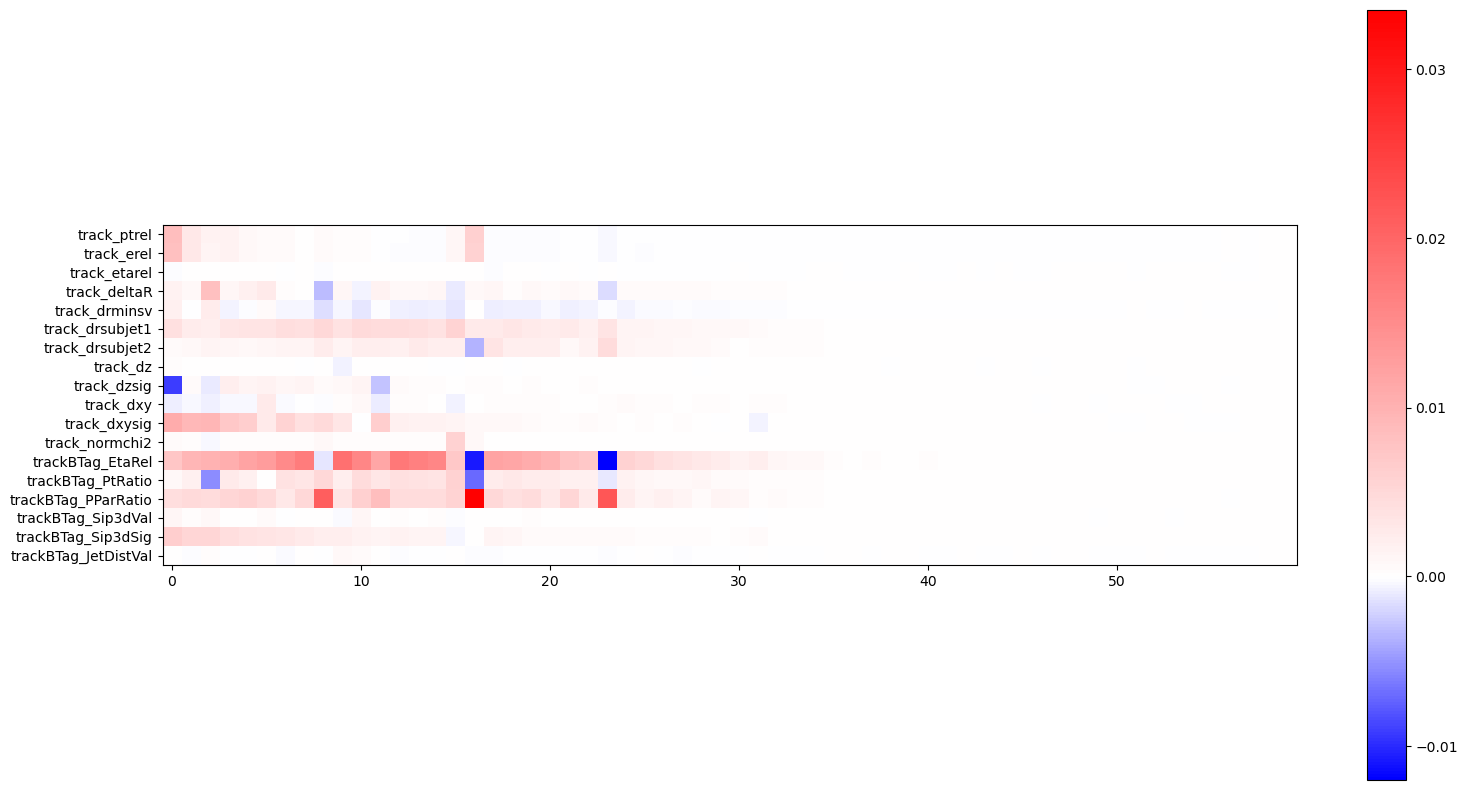

In [69]:
plt.figure(figsize=(16, 8))
divnorm = colors.TwoSlopeNorm(vmin=Pall_1.min(), vcenter=0.0, vmax=Pall_1.max())
plt.imshow(Pall_1.numpy(), cmap="bwr", interpolation="None", norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_to_keep)), labels=params_to_keep)
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/track1_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

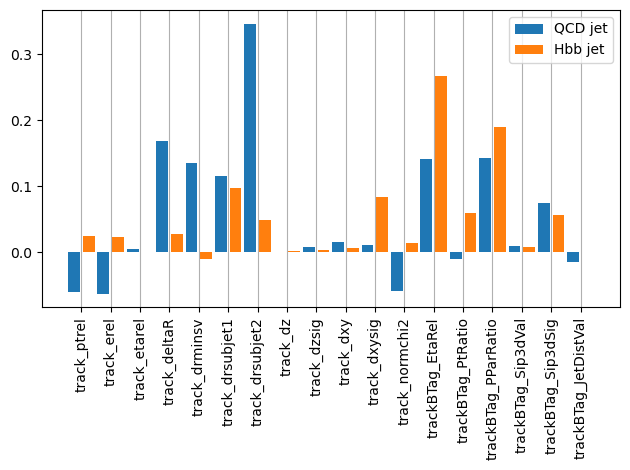

In [70]:
pos = 2 * np.arange(len(params_to_keep))
plt.bar(pos, torch.sum(Pall_0, 1).numpy(), align="center", label="QCD jet")
plt.bar(pos + 1, torch.sum(Pall_1, 1).numpy(), align="center", label="Hbb jet")
plt.xticks(pos + 0.5, params_to_keep, rotation="vertical")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/track_feats_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

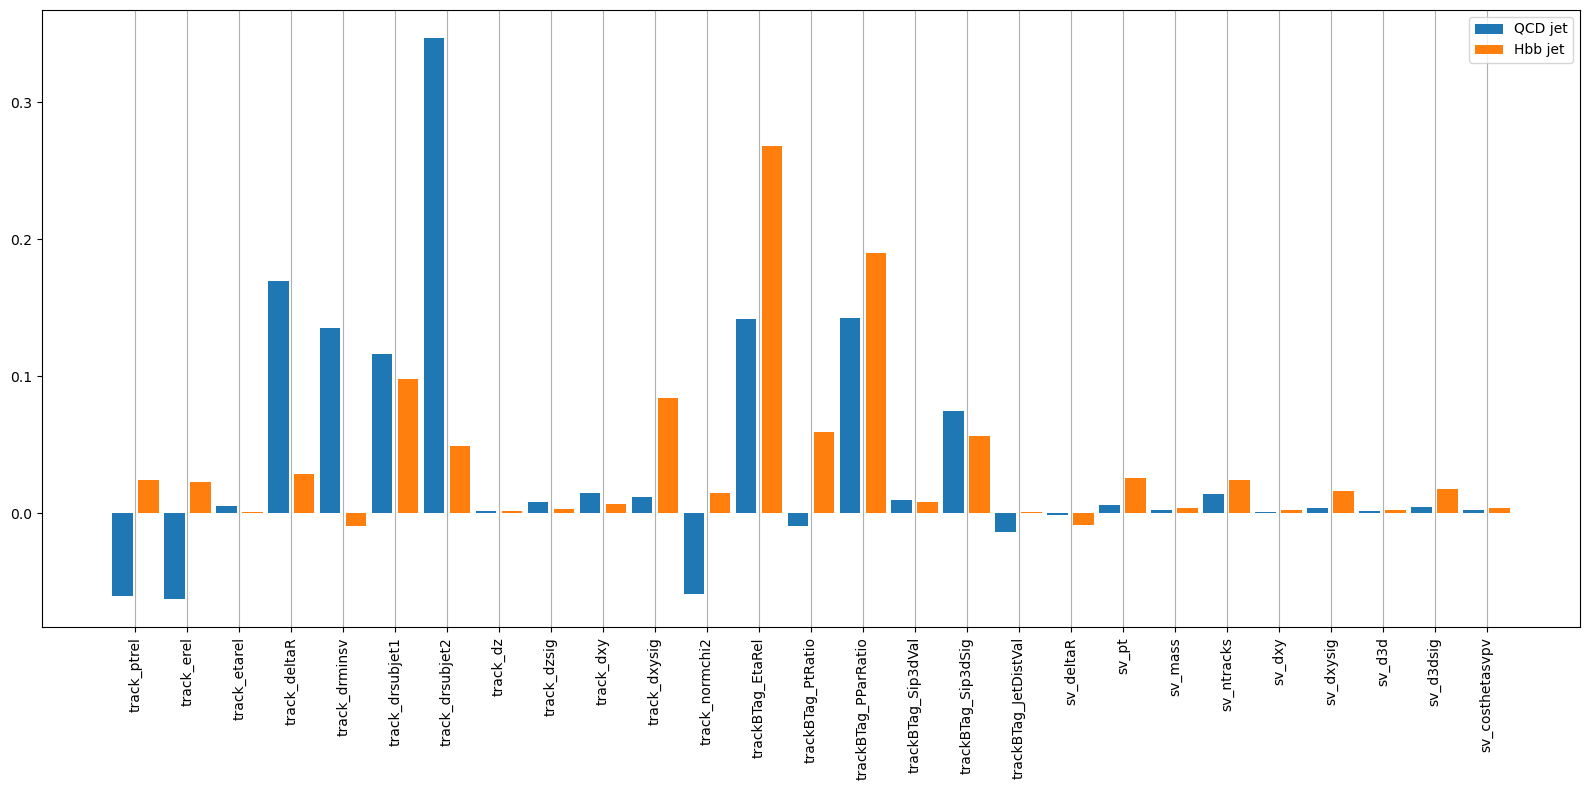

In [71]:
pos = 2 * np.arange(len(params_to_keep) + len(params_sv_to_keep))
plt.figure(figsize=(16, 8))
plt.bar(pos, np.append(torch.sum(Pall_0, 1).numpy(), torch.sum(Vall_0, 1).numpy()), align="center", label="QCD jet")
plt.bar(pos + 1, np.append(torch.sum(Pall_1, 1).numpy(), torch.sum(Vall_1, 1).numpy()), align="center", label="Hbb jet")
plt.xticks(pos + 0.5, params_to_keep + params_sv_to_keep, rotation="vertical")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/trackNvert_feats_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

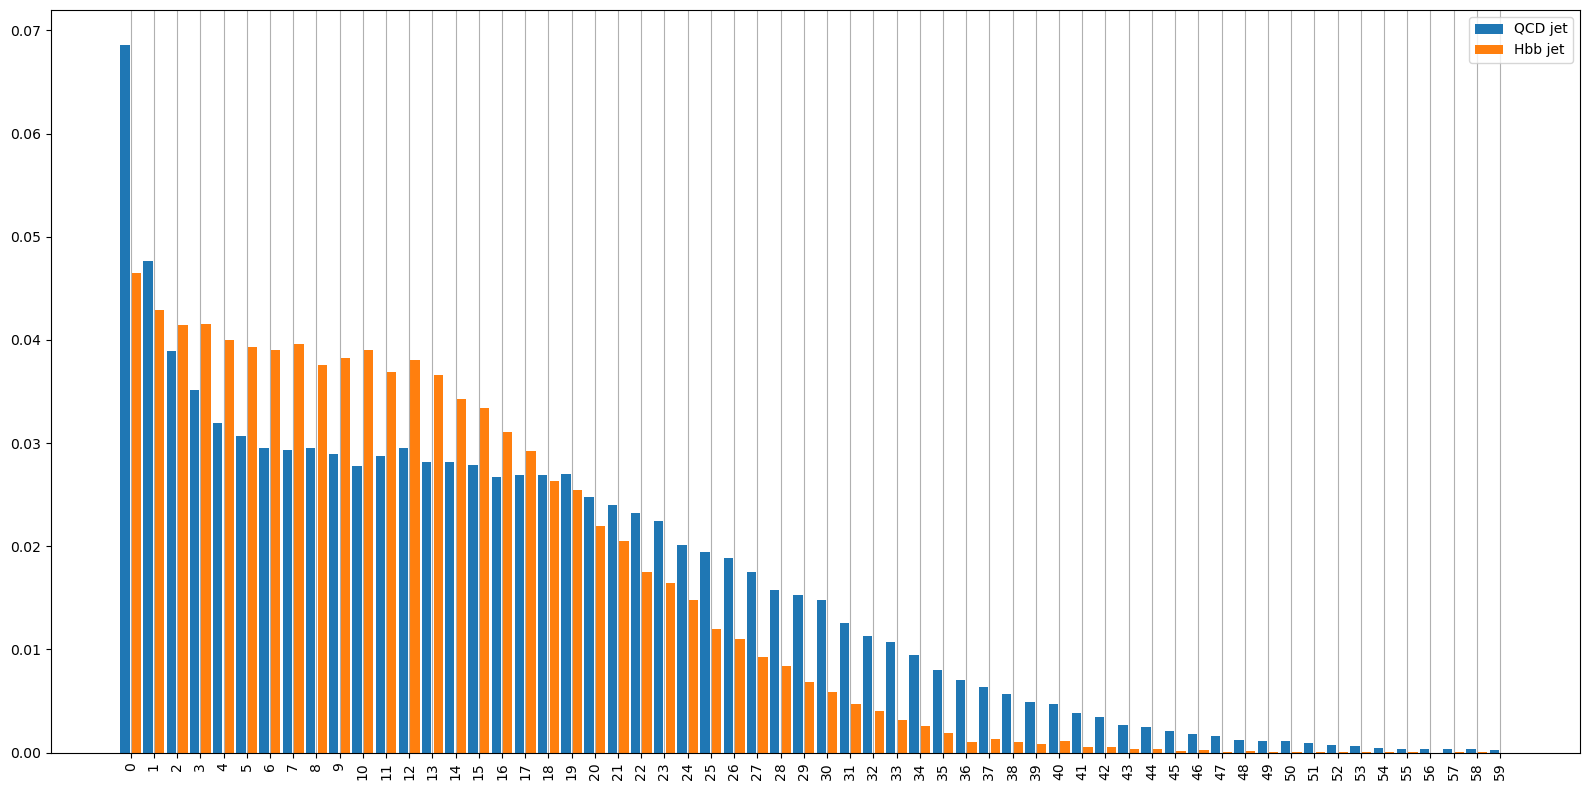

In [72]:
plt.figure(figsize=(16, 8))
pos = 2 * np.arange(Ntracks)
plt.bar(pos, torch.sum(Pall_0, 0).numpy(), align="center", label="QCD jet")
plt.bar(pos + 1, torch.sum(Pall_1, 0).numpy(), align="center", label="Hbb jet")
plt.xticks(pos + 0.5, list(map(int, pos / 2)), rotation="vertical")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/track_tracks_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()

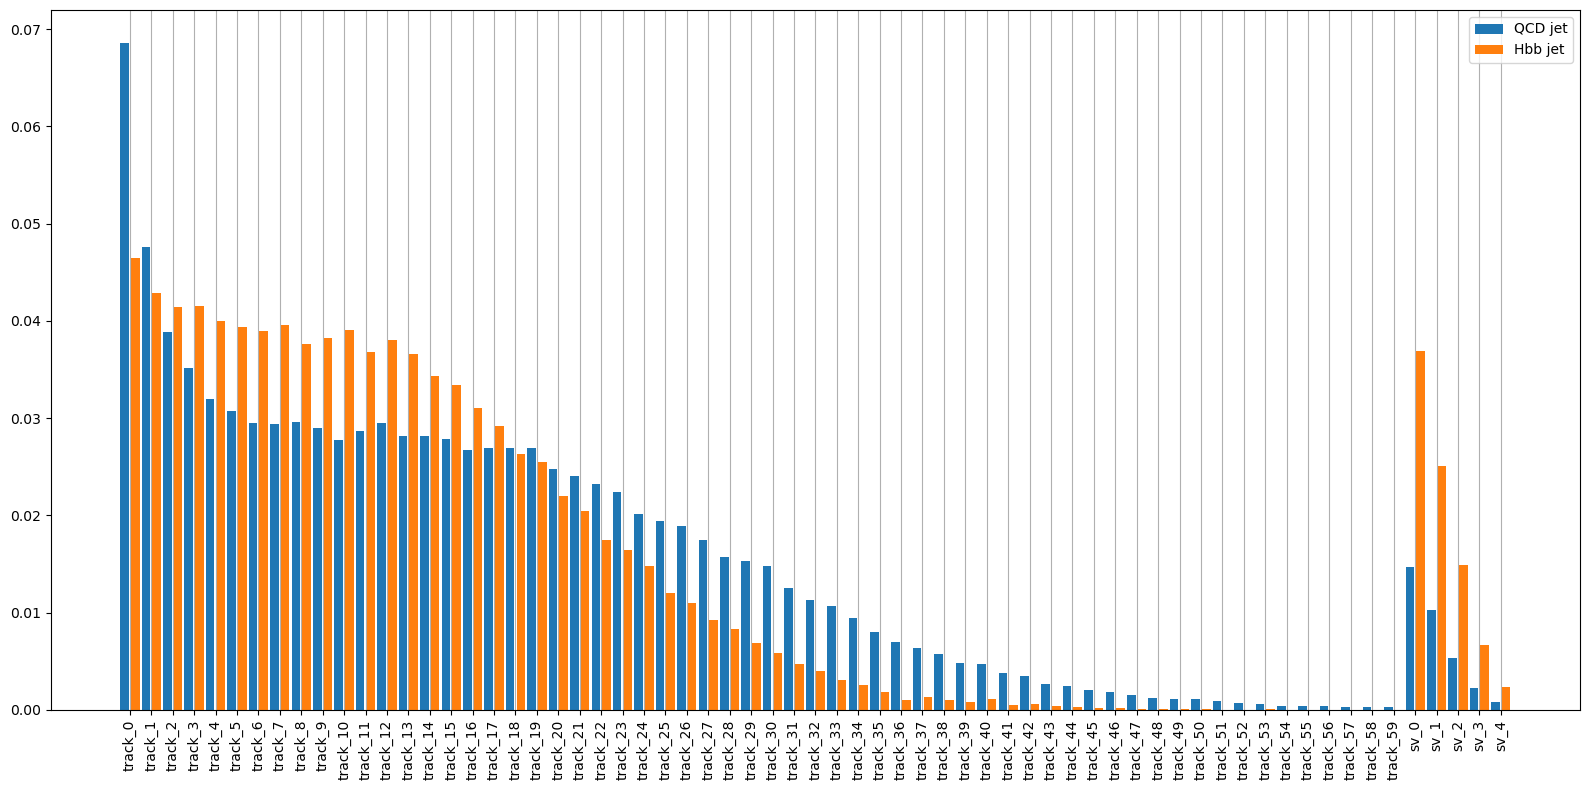

In [73]:
plt.figure(figsize=(16, 8))
pos = 2 * np.arange(Ntracks + Nverts)
plt.bar(
    pos,
    np.append(torch.sum(Pall_0, 0).reshape(-1).numpy(), torch.sum(Vall_0, 0).reshape(-1).numpy()),
    align="center",
    label="QCD jet",
)
plt.bar(
    pos + 1,
    np.append(torch.sum(Pall_1, 0).reshape(-1).numpy(), torch.sum(Vall_1, 0).reshape(-1).numpy()),
    align="center",
    label="Hbb jet",
)
xticklabels = ["track_{}".format(i) for i in range(Ntracks)] + ["sv_{}".format(i) for i in range(Nverts)]
# plt.xticks(pos + 0.5, list(map(int, pos/2)), rotation='vertical')
plt.xticks(pos + 0.5, xticklabels, rotation="vertical")
plt.grid(axis="x")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/plots_xAI/trackNverts_LRP_{}.pdf".format(tag), bbox_inches="tight")
plt.show()